In [68]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchmetrics
from tqdm import tqdm
import torchaudio
from datasets import load_dataset, DatasetDict
import numpy as np
import random


In [107]:
SEED = 42
SAMPLE_RATE = 16000
BATCH_SIZE = 32
NUM_WORKERS = 23
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [88]:
ds = load_dataset("Usernameeeeee/df_462700_2")

ds_split = ds["train"].train_test_split(test_size=0.3, seed=SEED, shuffle=True)
test_and_valid = ds_split["test"].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

ds = DatasetDict({
    "train": ds_split["train"],
    "valid": test_and_valid["train"],
    "test": test_and_valid["test"],
})

print("Dataset splits:", {k: v.shape for k, v in ds.items()})

Dataset splits: {'train': (323890, 3), 'valid': (69405, 3), 'test': (69406, 3)}


In [89]:
# -----------------------------
# Audio transforms
# -----------------------------
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=2048,
    hop_length=256,
    n_mels=64,
)
db_transform = torchaudio.transforms.AmplitudeToDB()

In [105]:
# -----------------------------
# Collate function with Mel computation
# -----------------------------
# Define augmentations
augmentations = torch.nn.Sequential(
    torchaudio.transforms.Vol(gain=random.uniform(-5, 5)),
)

def collate_fn(batch):
    xs, ys = [], []

    for b in batch:
        waveform = torch.tensor(b["audio"]).float()

        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)

        # Apply waveform-level augmentation
        if random.random() < 0.5:  # 50% chance
            # Example augmentations
            if random.random() < 0.5:
                waveform = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)(waveform.unsqueeze(0)).squeeze(0)
            if random.random() < 0.5:
                waveform = torchaudio.transforms.TimeMasking(time_mask_param=35)(waveform.unsqueeze(0)).squeeze(0)
            if random.random() < 0.3:
                waveform = waveform + 0.005 * torch.randn_like(waveform)  # Add noise

        mel = mel_transform(waveform)
        mel_db = db_transform(mel)

        xs.append(mel_db)
        ys.append(b["label"])

    max_len = max(x.shape[-1] for x in xs)
    xs_padded = torch.zeros((len(xs), 1, 64, max_len))
    for i, x in enumerate(xs):
        xs_padded[i, 0, :, :x.shape[-1]] = x

    return xs_padded, torch.tensor(ys).float().unsqueeze(1)
train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(ds["valid"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [91]:
# -----------------------------
# Simplified CNN
# -----------------------------
class SimpleAudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Linear(32, 32),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SimpleAudioCNN().to(DEVICE)

In [101]:
# -----------------------------
# Loss, optimizer, metric
# -----------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
metric_acc = torchmetrics.classification.BinaryAccuracy().to(DEVICE)

In [106]:
# -----------------------------
# Training loop
# -----------------------------
EPOCHS = 20
best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_acc = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_acc += metric_acc(out, y) * x.size(0)

    scheduler.step()
    train_loss /= len(ds["train"])
    train_acc /= len(ds["train"])

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc += metric_acc(out, y) * x.size(0)

    val_loss /= len(ds["valid"])
    val_acc /= len(ds["valid"])

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_simple_cnn.pt")
        print("✅ Saved new best model!")

Epoch 1/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.32it/s]


Epoch 1/20 | Train Loss: 45532349.8036 | Train Acc: 0.5509 | Val Loss: 6746.0413 | Val Acc: 0.5408
✅ Saved new best model!


Epoch 2/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.25it/s] 


Epoch 2/20 | Train Loss: 29669625.4414 | Train Acc: 0.5480 | Val Loss: 1193666.9894 | Val Acc: 0.7312
✅ Saved new best model!


Epoch 3/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.88it/s]


Epoch 3/20 | Train Loss: 76158.2630 | Train Acc: 0.6190 | Val Loss: 209.7152 | Val Acc: 0.5514


Epoch 4/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 78.25it/s]


Epoch 4/20 | Train Loss: 6268749.3746 | Train Acc: 0.5676 | Val Loss: 1082.0155 | Val Acc: 0.7770
✅ Saved new best model!


Epoch 5/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.92it/s] 


Epoch 5/20 | Train Loss: 2564945.2582 | Train Acc: 0.5812 | Val Loss: 5309.2329 | Val Acc: 0.5043


Epoch 6/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 77.88it/s] 


Epoch 6/20 | Train Loss: 5379.1513 | Train Acc: 0.6109 | Val Loss: 62.8328 | Val Acc: 0.7569


Epoch 7/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 77.43it/s] 


Epoch 7/20 | Train Loss: 39070.1924 | Train Acc: 0.5521 | Val Loss: 106.3478 | Val Acc: 0.3278


Epoch 8/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 78.15it/s] 


Epoch 8/20 | Train Loss: 810.8450 | Train Acc: 0.5186 | Val Loss: 16.8640 | Val Acc: 0.7006


Epoch 9/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.84it/s] 


Epoch 9/20 | Train Loss: 23.0226 | Train Acc: 0.5431 | Val Loss: 0.7645 | Val Acc: 0.7783
✅ Saved new best model!


Epoch 10/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.31it/s]


Epoch 10/20 | Train Loss: 1.2032 | Train Acc: 0.5315 | Val Loss: 0.7864 | Val Acc: 0.7779


Epoch 11/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 78.07it/s] 


Epoch 11/20 | Train Loss: 16.9027 | Train Acc: 0.5313 | Val Loss: 0.6579 | Val Acc: 0.5505


Epoch 12/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 77.71it/s]


Epoch 12/20 | Train Loss: 363.3516 | Train Acc: 0.6273 | Val Loss: 0.6440 | Val Acc: 0.5525


Epoch 13/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 77.46it/s] 


Epoch 13/20 | Train Loss: 12317.2164 | Train Acc: 0.6522 | Val Loss: 31.1876 | Val Acc: 0.5507


Epoch 14/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.88it/s] 


Epoch 14/20 | Train Loss: 98138.3771 | Train Acc: 0.5707 | Val Loss: 0.9334 | Val Acc: 0.5557


Epoch 15/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 77.29it/s]


Epoch 15/20 | Train Loss: 250667.6782 | Train Acc: 0.5769 | Val Loss: 80.7818 | Val Acc: 0.4181


Epoch 16/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.94it/s] 


Epoch 16/20 | Train Loss: 1352130.6499 | Train Acc: 0.5434 | Val Loss: 109.4669 | Val Acc: 0.5482


Epoch 17/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 77.17it/s] 


Epoch 17/20 | Train Loss: 16380915.7056 | Train Acc: 0.5764 | Val Loss: 190.5996 | Val Acc: 0.5508


Epoch 18/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 78.09it/s]


Epoch 18/20 | Train Loss: 146037.9762 | Train Acc: 0.5330 | Val Loss: 1.1482 | Val Acc: 0.5468


Epoch 19/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 76.68it/s]


Epoch 19/20 | Train Loss: 54881625.5226 | Train Acc: 0.5595 | Val Loss: 1406.1222 | Val Acc: 0.5353


Epoch 20/20 [Valid]: 100%|██████████| 1446/1446 [00:18<00:00, 77.41it/s]


Epoch 20/20 | Train Loss: 34585017.9387 | Train Acc: 0.5549 | Val Loss: 1432.6479 | Val Acc: 0.8119
✅ Saved new best model!


In [94]:
# Load model
model = SimpleAudioCNN().to(DEVICE)
model.load_state_dict(torch.load("best_simple_cnn.pt", map_location=DEVICE))
model.eval()
print("✅ Loaded best model and set to eval mode")

✅ Loaded best model and set to eval mode


In [95]:
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()  # Threshold 0.5

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())      # append batch probabilities
        all_labels.extend(y.cpu().numpy().flatten())  #

Testing: 100%|██████████| 1446/1446 [00:19<00:00, 75.66it/s] 


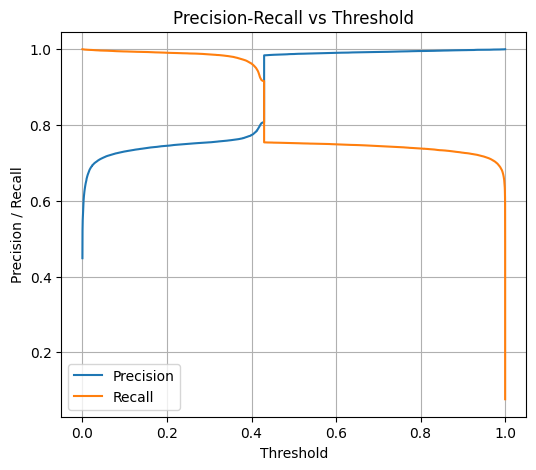

In [96]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

labels = np.array(all_labels)
probs = np.array(all_probs)

precision, recall, thresholds = precision_recall_curve(labels, probs)

# Plot Precision-Recall
plt.figure(figsize=(6,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [97]:
# -----------------------------
# Metrics
# -----------------------------
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=ds["train"].features["label"].names, digits=3))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

✅ Test Accuracy: 88.45%

Classification Report:
              precision    recall  f1-score   support

       other      0.831     0.992     0.905     38272
       drone      0.987     0.752     0.854     31134

    accuracy                          0.885     69406
   macro avg      0.909     0.872     0.879     69406
weighted avg      0.901     0.885     0.882     69406


Confusion Matrix:
[[37973   299]
 [ 7716 23418]]


In [98]:
def infer_from_dataset_binary(model, dataset, threshold=0.5, drone_only=False, other_only=False):
    results = []

    test_dataset_labels = dataset.features["label"].names
    training_labels = ds["train"].features["label"].names

    for item in tqdm(dataset, desc="Inference"):
        if test_dataset_labels[item["label"]] != "drone" and drone_only:
            continue
        if test_dataset_labels[item["label"]] != "other" and other_only:
            continue

        waveform = torch.tensor(item["audio"]["array"]).float()
        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)

        # Compute Mel + dB on the fly
        mel = mel_transform(waveform)
        mel_db = db_transform(mel).unsqueeze(0).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logits = model(mel_db)
            prob = torch.sigmoid(logits).item()
            pred_label = training_labels[1] if prob > threshold else training_labels[0]

        true_label = test_dataset_labels[item["label"]]

        results.append({
            "true_label": true_label,
            "pred_label": pred_label,
            "confidence": round(prob, 3)
        })

    df_results = pd.DataFrame(results)
    accuracy = (df_results["true_label"] == df_results["pred_label"]).mean()
    print(f"\n✅ Accuracy on ds_test_online: {accuracy*100:.2f}% {'(Drone only)' if drone_only else ''}")

    return df_results

In [99]:
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
df_test_results = infer_from_dataset_binary(model, ds_test_online, drone_only=False)

Inference: 100%|██████████| 893/893 [00:00<00:00, 1108.31it/s]


✅ Accuracy on ds_test_online: 48.15% 


In [100]:
ds_test_online = load_dataset("Usernameeeeee/drone_test_2", split="test")
df_test_results = infer_from_dataset_binary(model, ds_test_online, drone_only=True)

Inference: 100%|██████████| 2805/2805 [00:02<00:00, 1129.88it/s]



✅ Accuracy on ds_test_online: 35.70% (Drone only)
